# External DLA {-} 

This first cell contains most of the functions used in the simulation of external DLA. 

In [141]:
# packages used
import math
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import colors
import random
import time 
import datetime

# helper functions 

def taxicab_distance(pos_one, pos_two): # L1 distance 
    return abs(pos_one[0]-pos_two[0]) + abs(pos_one[1]-pos_two[1])

def distance_to_cluster(sensor, cluster): 
    distances = [taxicab_distance(sensor, particle) for particle in cluster]
    return min(distances)

def sensor_dist(sensor, cluster):
    return distance_to_cluster(sensor,cluster)

def distribute_particles(area, p, matrix):
    particles = []
    for site in area: # each site is a location (x,y); add site to particles with probability p
        if random.random() < p:
            particles.append(site)
            matrix[site[1], site[0]] = 2
    return particles 

def check_atEdge(pos, N):
    if pos[0] >= N-1 or pos[0] == 0 or pos[1] >= N-1 or pos[1] == 0: 
        return True
    else:
        return False
    
def check_stuck(pos, N, matrix): 
    stuck = False
    atEdge = check_atEdge(pos, N)
    if not atEdge:
        down = matrix[pos[1]+1, pos[0]]
        up = matrix[pos[1]-1, pos[0]]
        right = matrix[pos[1], pos[0]+1]
        left = matrix[pos[1], pos[0]-1]
        if down == 1 or up == 1 or right == 1 or left == 1: 
            stuck = True
    return stuck
#----------------------------------------------------------------------------------------------
# these functions return true if a particle already occupies one of these positions; 
# aids in the implementation of the exclusion property
def check_left(pos, matrix):
    left = matrix[pos[1], max(pos[0]-1, 0)]
    if left == 0:  
        return True
    else:
        return False
    
def check_right(pos, matrix):
    right = matrix[pos[1], min(pos[0]+1, matrix.shape[0]-1)]
    if right == 0:  
        return True
    else:
        return False

def check_up(pos, matrix):
    up = matrix[max(pos[1]-1, 0), pos[0]]
    if up == 0:  
        return True
    else:
        return False
    
def check_down(pos, matrix):
    down = matrix[min(pos[1]+1, matrix.shape[0]-1), pos[0]]
    if down == 0:  
        return True
    else:
        return False
#----------------------------------------------------------------------------------------------
# step particles and enforce exclusion property
def step_particles(particles, matrix, N):
    for i in range(len(particles)):
        p = particles[i]
        if matrix[p[1], p[0]] == 2: 
            x = p[0]
            y = p[1]
            choice = random.choice([0,1,2,3])
            if choice == 0 and check_down(p, matrix):
                matrix[min(y+1, N-1), x], matrix[y,x] = 2, 0
                particles[i] = (x, min(y+1, N-1))
            elif choice == 1 and check_up(p, matrix):
                matrix[max(y-1, 0), x], matrix[y,x] = 2, 0
                particles[i] = (x, max(y-1, 0))
            elif choice == 2 and check_right(p, matrix):
                matrix[y, min(x+1, N-1)], matrix[y,x] = 2, 0
                particles[i] = (min(x+1, N-1), y)
            elif choice == 3 and check_left(p, matrix):
                matrix[y, max(x-1, 0)], matrix[y,x] = 2, 0
                particles[i] = (max(x-1, 0), y)   
                

# this function is an analogue of the flood-fill algorithm, but returns a list of pairs (x,y) which denote 
# each of the particles added to the cluster
def snap_to_cluster(data, start_coords, fill_value):
    
    xsize, ysize = data.shape
    orig_value = data[start_coords[0], start_coords[1]]
    
    stack = set(((start_coords[0], start_coords[1]),))
    
    if fill_value == orig_value: 
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")
    
    ret = [] # will contain the positions of particles that are added to the cluster
    
    while stack: 
        x, y = stack.pop()
    
        if data[x,y] == orig_value:
            data[x,y] = fill_value
            ret.append((y,x))
            
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))
                
    return ret
                
                
def num_neighbors(particle, matrix):
    num = 0 # particle = (x, y)
    if particle[0] < matrix.shape[0]-1: # if particle not on right boundary
        right = matrix[particle[1], min(particle[0]+1, matrix.shape[0]-1)]
    else: 
        right = 0 # if particle on right boundary, no right neighbor 
    
    if particle[0] > 1: # particle not on left boundary
        left = matrix[particle[1], max(particle[0]-1, 0)] 
    else: 
        left = 0
        
    if particle[1] < matrix.shape[0]: # particle not on bottom boundary
        down = matrix[min(particle[1]+1, matrix.shape[0]-1), particle[0]]
    else: 
        down = 0
        
    if particle[1] > 1: # particle not on upper boundary
        up = matrix[max(particle[1]-1, 0), particle[0]]
    else: 
        up = 0
    
    num = abs(right) + abs(left) + abs(up) + abs(down)
    
    return num

def total_edge_count(cluster, matrix):
    total = 0
    for particle in cluster: 
        num = 4 - num_neighbors(particle, matrix)
        total += num
    return total

def flood_fill(data, start_coords, fill_value):
    
    xsize, ysize = data.shape
    orig_value = data[start_coords[0], start_coords[1]]

    stack = set(((start_coords[0], start_coords[1]),))
    if fill_value == orig_value:
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")

    while stack:
        x, y = stack.pop()

        if data[x, y] == orig_value:
            data[x, y] = fill_value
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))
                
def hole_fill(matrix):
    flood_fill(matrix,(0,0),-1)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] == 0:
                matrix[i][j] = -1
    flood_fill(matrix, (0,0), 0)
    
def rotate_matrix(matrix):
    rot_mat = np.transpose(matrix)
    rot_mat = np.flip(rot_mat, axis=0)
    return rot_mat 
    
def check_boundary(matrix): 
    if np.any(matrix[1,:] == 1): # checks if there are any 1s in the 0th row
        return True
    elif np.any(matrix[matrix.shape[0]-2, :] == 1): # checks if there are any 1s in the Nth row
        return True
    elif np.any(matrix[:, 1] == 1): # checks if there are any 1s in the 0th column
        return True
    elif np.any(matrix[:, matrix.shape[0]-2] == 1): # checks if there are any 1s in the Nth column
        return True
    else: 
        return False

# Test particle distribution and walk function

This cell tests that the particles are initially distributed in $\Gamma^N \setminus \Lambda_0^N$ according to a uniform distribution. Each site of $\Gamma^N$ has probability `p` of being occupied by a particle. We can experiment with different seed shapes by uncommenting/commenting the relevant blocks of code (note that only one of these blocks may be uncommented).

Number of 2s in matrix: 631
Length of particles: 631


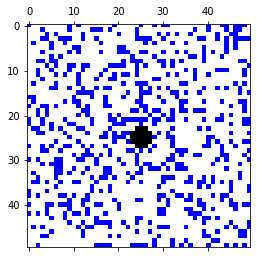

In [75]:
N = 50
p = 0.25
k = .01
S = 0.05
s = .02
c = .1

matrix = np.zeros((N,N))

# circular seed
for row in range(N):
    for col in range(N):
        if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
            matrix[row,col] = 1

# square seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-S*N and col < N/2+S*N and row > N/2-S*N and row < N/2+S*N:
#             matrix[row,col]=1


# cross seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-c*N and col < N/2 +c*N and row > N/2 - s*N and row < N/2 + s*N:
#             matrix[row,col]=1
#         elif col > N/2-s*N and col < N/2 +s*N and row > N/2 - c*N and row < N/2 + c*N:
#             matrix[row,col]=1

cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))] # valid area to spawn particles (grid \ init cluster)

particles = distribute_particles(valid_area, p, matrix)

# for p in particles:
#     matrix[p[1], p[0]] = 2
    
print('Number of 2s in matrix:',(matrix==2).sum())
print('Length of particles:', len(particles))

cmap = colors.ListedColormap(['white', 'black', 'blue'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()


Next, we test that the particles walk according to a symmetric reflected random walk with exclusion. Keep evaluating this cell to see the particles walk and attach to the seed cluster.

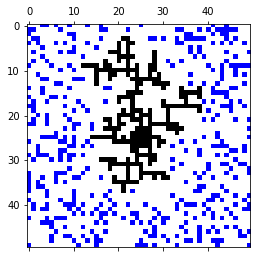

In [131]:
step_particles(particles, matrix, N)
for i in range(len(particles)):
    q = particles[i]
    if matrix[q[1], q[0]] == 2:
        particle_stuck = check_stuck(q, N, matrix)
        if particle_stuck:
            to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
            cluster.extend(to_add)
            
cmap = colors.ListedColormap(['white', 'black', 'blue'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

# Simulation for fixed $N$ and increasing $N$. 

Suppose we fix a value $N$. This is the sidelength of $\Gamma^N.$ We run the external DLA growth model on this $\Gamma^N$. We also want to be able to run the external DLA growth model in a loop over increasing $N$ to study the limiting properties of $\Lambda_{TN^2}^N$ for large $N$.

## Fixed $N$

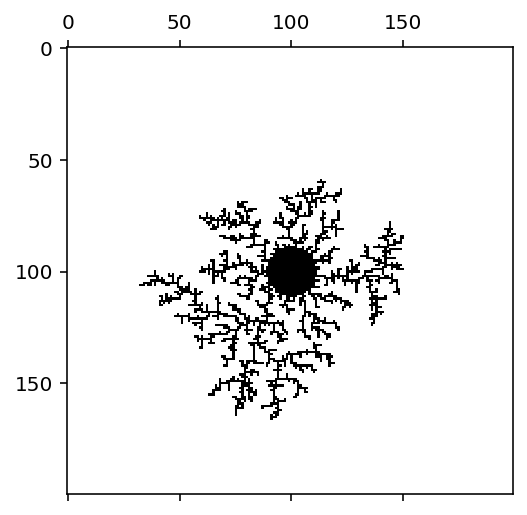

CPU times: user 47.6 s, sys: 322 ms, total: 47.9 s
Wall time: 53.8 s


In [148]:
%%time

N = 200   # Grid size
p = 0.25  # Probability of grid site being occupied with a particle at time 0
T = 0.01  # Particles stop walking at time t = T*N^2
k = 0.01  # Parameter for determining size of initial circular seed cluster 

S = 0.05 # Parameters for square/cross initial seeds
s = .02
c = .1

matrix = np.zeros((N,N))

# circular seed
for row in range(N):
    for col in range(N):
        if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
            matrix[row,col] = 1

# square seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-s*N and col < N/2+s*N and row > N/2-s*N and row < N/2+s*N:
#             matrix[row,col]=1


# cross seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-c*N and col < N/2 +c*N and row > N/2 - s*N and row < N/2 + s*N:
#             matrix[row,col]=1
#         elif col > N/2-s*N and col < N/2 +s*N and row > N/2 - c*N and row < N/2 + c*N:
#             matrix[row,col]=1
            

cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))]

particles = distribute_particles(valid_area, p, matrix)

P = len(particles)

particles_added = 0
t = 0

while particles_added < int(P) and t <= int(T*N**2): 
    step_particles(particles, matrix, N)
    for i in range(len(particles)):
        q = particles[i]
        if matrix[q[1], q[0]] == 2:
            particle_stuck = check_stuck(q, N, matrix)
            if particle_stuck:
                to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                cluster.extend(to_add)
                particles_added += len(to_add)
    t+=1

if (matrix==2).sum() > 0: 
    cmap = colors.ListedColormap(['white', 'black', 'white'])
else: 
    cmap = colors.ListedColormap(['white', 'black'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

## Increasing $N$

The next cell runs the simulation in a loop over $N$ between $N = N_0$ and $N = M.$ We introduce a `step` variable that helps to limit computational time taken to complete the loop. 

N = 150 
Time taken to complete: 16.01 seconds 
Percentage of particles added to cluster: 22.70% 
Percentage of grid occupied by cluster: 6.62%



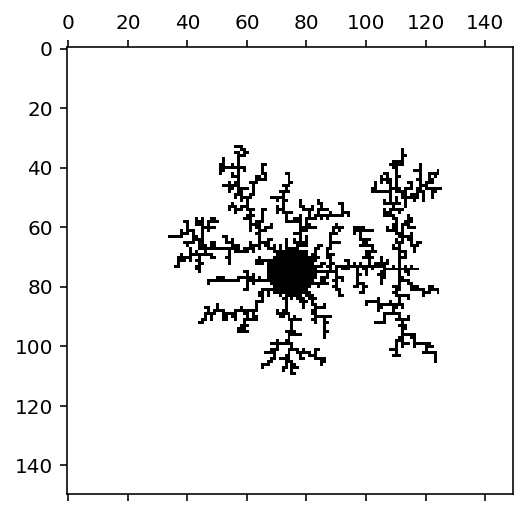

N = 160 
Time taken to complete: 18.94 seconds 
Percentage of particles added to cluster: 18.06% 
Percentage of grid occupied by cluster: 5.48%



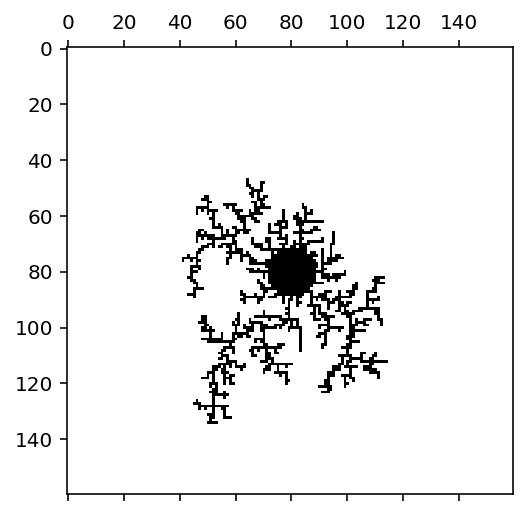

N = 170 
Time taken to complete: 26.99 seconds 
Percentage of particles added to cluster: 26.02% 
Percentage of grid occupied by cluster: 7.46%



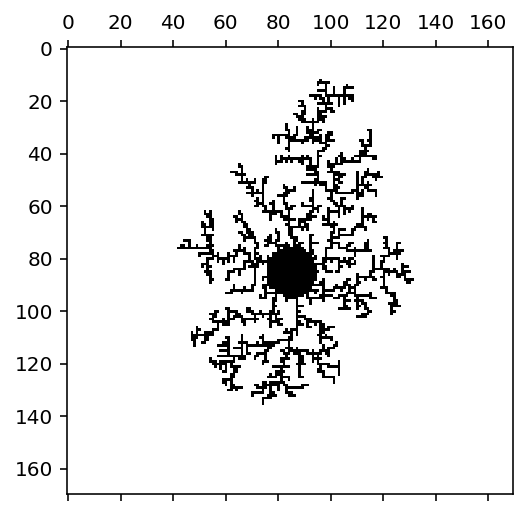

N = 180 
Time taken to complete: 35.31 seconds 
Percentage of particles added to cluster: 31.55% 
Percentage of grid occupied by cluster: 8.85%



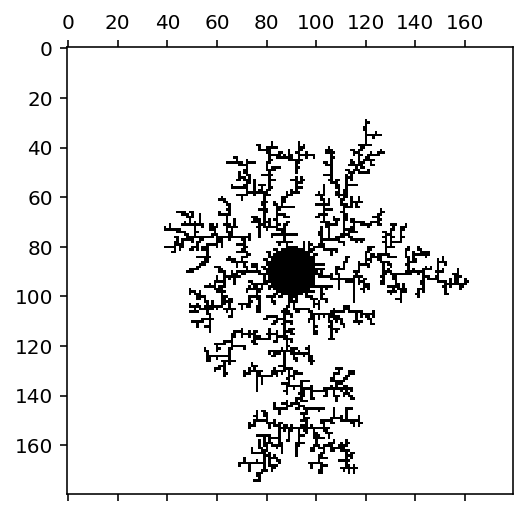

N = 190 
Time taken to complete: 40.16 seconds 
Percentage of particles added to cluster: 23.90% 
Percentage of grid occupied by cluster: 6.84%



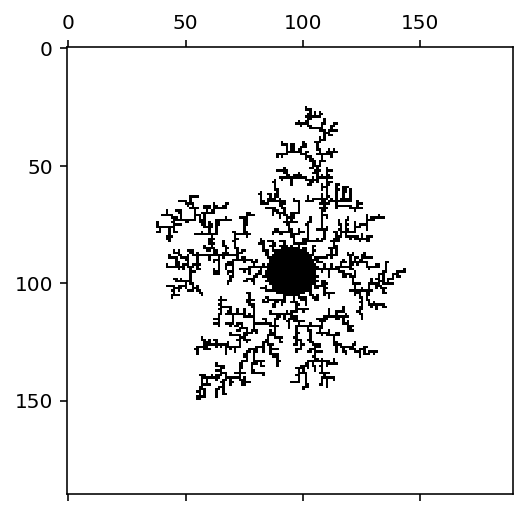

N = 200 
Time taken to complete: 51.12 seconds 
Percentage of particles added to cluster: 27.71% 
Percentage of grid occupied by cluster: 7.79%



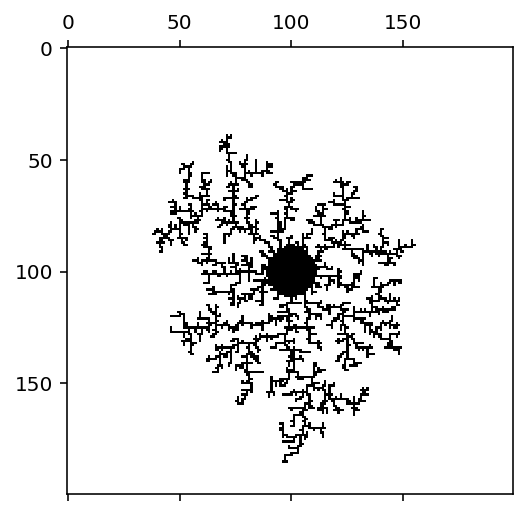

CPU times: user 2min 48s, sys: 894 ms, total: 2min 48s
Wall time: 3min 10s


In [151]:
%%time

M = 200
N_0 = 150

p = 0.25
T = 0.01
k = 0.01

step = 10
for N in range(N_0, M + step, step):
    start = time.time()
    
    matrix = np.zeros((N,N))
    
    # Circular seed cluster
    for row in range(N+1):
        for col in range(N+1):
            if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
                matrix[row,col] = 1
                
    cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
    valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))] # valid area to spawn particles (grid \ initial cluster)

    particles = distribute_particles(valid_area, p, matrix)
    
    P = len(particles)
    
    # walk the particles until either: (1) time runs out or (2) all particles attach to cluster
    particles_added = 0
    t = 0
    while particles_added < int(P) and t <= int(T*N**2): 
        step_particles(particles, matrix, N)
        for i in range(len(particles)):
            q = particles[i]
            if matrix[q[1], q[0]] == 2:
                particle_stuck = check_stuck(q, N, matrix)
                if particle_stuck:
                    to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                    cluster.extend(to_add)
                    particles_added += len(to_add)
        t+=1
    
    end = time.time()
    print(f'N = {N} \nTime taken to complete: {(end-start):.2f} seconds \nPercentage of particles added to cluster: {(particles_added/P)*100:.2f}% \nPercentage of grid occupied by cluster: {(len(cluster)/N**2)*100:.2f}%\n')

    if (matrix==2).sum() > 0: 
        cmap = colors.ListedColormap(['white', 'black', 'white'])
    else: 
        cmap = colors.ListedColormap(['white', 'black'])


    plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
    plt.show()

# I. Random or deterministic limit.

Simulation number: 1 

	N = 100 
	Time taken to complete: 0:00:02.785628 
	Percentage of particles added to cluster: 10.88% 
	Percentage of grid occupied by cluster: 3.73% 
	 Corner sensor distance to cluster (normalized): 0.6700 
	 Side sensor distance to cluster (normalized): 0.3300 



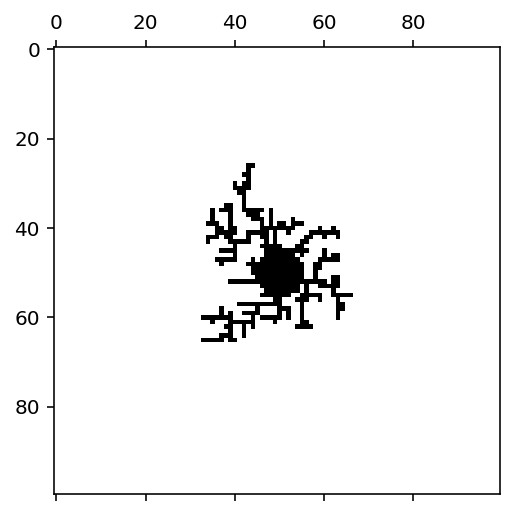

KeyboardInterrupt: 

In [152]:
%%time

M = 500
N_0 = 100

p = 0.25
T = 0.01
k = 0.01

step = 10

S = 10 # number of Monte Carlo simulations

side_sensor_data = []
corner_sensor_data = []

for s in range(S):
    print(f'Simulation number: {s+1} \n')
    start1 = time.time()
    
    corner_sensor_distances = []
    side_sensor_distances = []
    
    for N in range(N_0, M + step, step):
        start2 = time.time()

        matrix = np.zeros((N,N))
        
        corner_sensor = (int(.95*N), int(.95*N))
        side_sensor = (int(.95*N), N//2)
        
        # Circular seed cluster
        for row in range(N+1):
            for col in range(N+1):
                if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
                    matrix[row,col] = 1

        cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
        valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))] # valid area to spawn particles (grid \ initial cluster)

        particles = distribute_particles(valid_area, p, matrix)

        P = len(particles)

        # walk the particles until either: (1) time runs out or (2) all particles attach to cluster
        particles_added = 0
        t = 0
        
        while particles_added < int(P) and t <= int(T*N**2): 
            step_particles(particles, matrix, N)
            for i in range(len(particles)):
                q = particles[i]
                if matrix[q[1], q[0]] == 2:
                    particle_stuck = check_stuck(q, N, matrix)
                    if particle_stuck:
                        to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                        cluster.extend(to_add)
                        particles_added += len(to_add)
            t+=1
        
        # distance calculation
        corner_d = distance_to_cluster(corner_sensor, cluster)
        side_d = distance_to_cluster(side_sensor, cluster)
        # normalize the distances here: 
        corner_sensor_distances.append(corner_d/N) 
        side_sensor_distances.append(side_d/N)
        
        end2 = time.time()
        print(f'\tN = {N} \n\tTime taken to complete: {datetime.timedelta(seconds=(end2-start2))} \n\tPercentage of particles added to cluster: {(particles_added/P)*100:.2f}% \n\tPercentage of grid occupied by cluster: {(len(cluster)/N**2)*100:.2f}% \n\t Corner sensor distance to cluster (normalized): {corner_d/N:.4f} \n\t Side sensor distance to cluster (normalized): {side_d/N:.4f} \n')                
        
        # print image of cluster
        if (matrix==2).sum() > 0: 
            cmap = colors.ListedColormap(['white', 'black', 'white'])
        else: 
            cmap = colors.ListedColormap(['white', 'black'])
        
        plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
        plt.show()  
        
    corner_sensor_data.append(corner_sensor_distances) # store the distance data from this particular simulation
    side_sensor_data.append(side_sensor_distances)
    
    
    end1 = time.time()
    print(f'\nTime taken to complete simulation number {s+1}: {datetime.timedelta(seconds=(end1-start1))}')

### Store/load raw data from this simulation

In [131]:
import pickle

In [142]:
# store 
with open('N=500 corner sensor distance sample.txt', 'wb') as fp:
    pickle.dump(corner_sensor_data, fp)

with open('N=500 side sensor distance sample.txt', 'wb') as fp:
    pickle.dump(side_sensor_data, fp)

In [143]:
# load: uncomment this cell
with open('N=500 corner sensor distance sample.txt', 'rb') as fp:
    b1 = pickle.load(fp)

with open('N=500 side sensor distance sample.txt', 'rb') as fp:
    b2 = pickle.load(fp)

### Transform distance data

In [29]:
def normalize(lst): # normalizes a distance for the "physical distance"
    new_lst = []
    N = 100
    for d in lst: 
        new_lst.append(d/N)
        N += 10
    return new_lst

def transform(lst): 
    transformed_data = []
    n = len(lst[0])
    for i in range(n):
        transformed_data.append([])
    for i in range(n):
        for l in lst:
            transformed_data[i].append(l[i])
    return transformed_data

def normalize_transform(data):
    normalized_data = [normalize(data[i]) for i in range(len(data))]
    return transform(normalized_data)

In [148]:
corner_variances = [np.var(x) for x in corner_data]
corner_var_data = [(100+10*i, corner_variances[i]) for i in range(len(corner_variances))]

side_variances = [np.var(x) for x in side_data]
side_var_data = [(100+10*i, side_variances[i]) for i in range(len(side_variances))]

corner_means = [np.mean(x) for x in corner_data]
corner_mean_data = [(100+10*i, corner_means[i]) for i in range(len(corner_means))]

side_means = [np.mean(x) for x in side_data]
side_mean_data = [(100+10*i, side_means[i]) for i in range(len(side_means))]

#### Variance of distances as a function of $N$

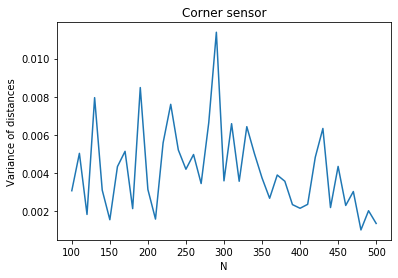

In [149]:
plt.xlabel('N')
plt.ylabel('Variance of distances')
plt.title('Corner sensor')
plt.plot(*zip(*corner_var_data))
plt.show()

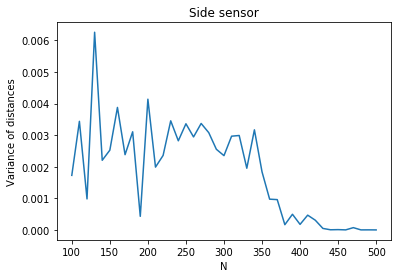

In [150]:
plt.xlabel('N')
plt.ylabel('Variance of distances')
plt.title('Side sensor')
plt.plot(*zip(*side_var_data))
plt.show()

#### Means of distances as function of $N$

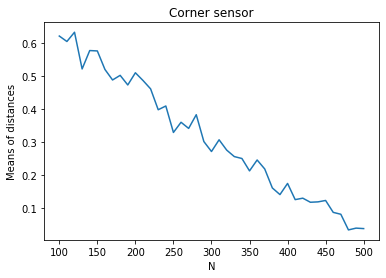

In [151]:
plt.xlabel('N')
plt.ylabel('Means of distances')
plt.title('Corner sensor')
plt.plot(*zip(*corner_mean_data))
plt.show()

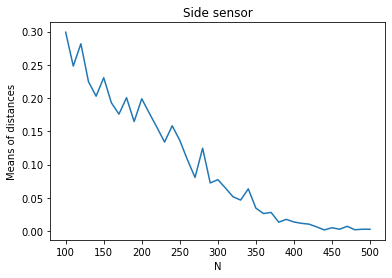

In [152]:
plt.xlabel('N')
plt.ylabel('Means of distances')
plt.title('Side sensor')
plt.plot(*zip(*side_mean_data))
plt.show()

#### Histograms of distances 

(0.0, 10.0)

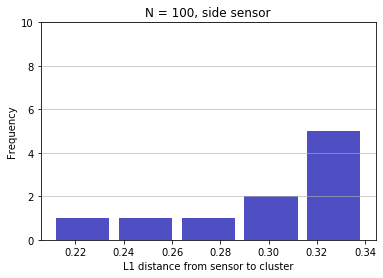

In [154]:
n, bins, patches = plt.hist(x=side_data[0], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 100, side sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

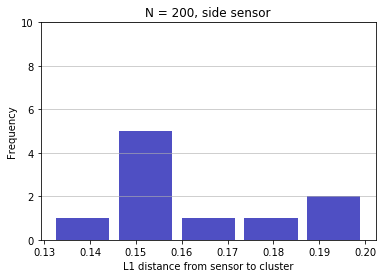

In [156]:
n, bins, patches = plt.hist(x=side_data[9], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 200, side sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

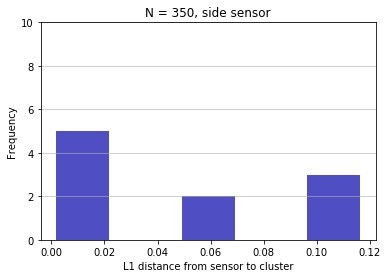

In [157]:
n, bins, patches = plt.hist(x=side_data[23], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 350, side sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

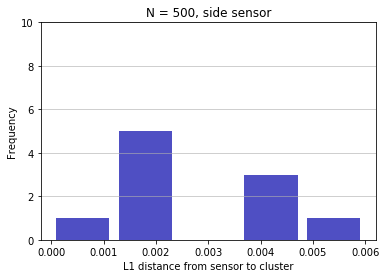

In [158]:
n, bins, patches = plt.hist(x=side_data[-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 500, side sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

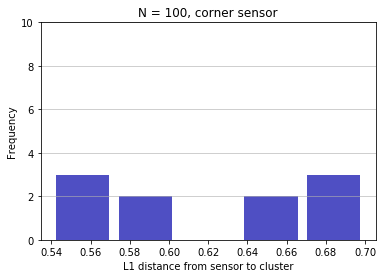

In [159]:
n, bins, patches = plt.hist(x=corner_data[0], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 100, corner sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

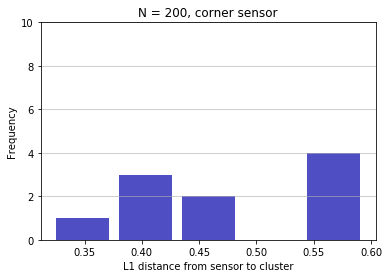

In [160]:
n, bins, patches = plt.hist(x=corner_data[9], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 200, corner sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

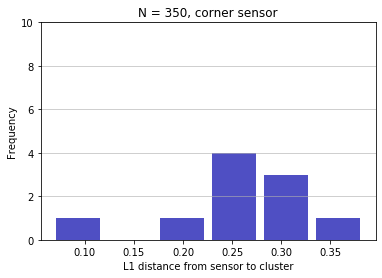

In [161]:
n, bins, patches = plt.hist(x=corner_data[23], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 350, corner sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

(0.0, 10.0)

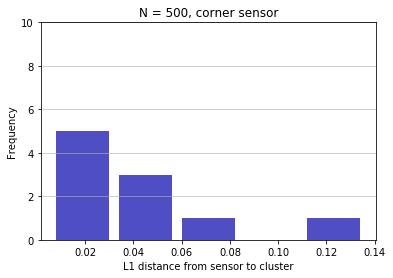

In [162]:
n, bins, patches = plt.hist(x=corner_data[-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L1 distance from sensor to cluster')
plt.ylabel('Frequency')
plt.title('N = 500, corner sensor')
#plt.text(950, 22, r'$\mu = 947.90$, $\sigma^2 = 26.75$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq%10 else maxfreq+10)

# Properties of the limit 

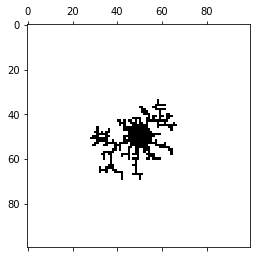

N = 100 
	Time taken to complete: 0:00:03.144920 
	Percentage of particles added to cluster: 11.01% 
	Percentage of grid occupied by cluster: 3.75% 
	Hole count: 10 
	Hole volume (normalized): 0.001 
	Boundary length (normalized): 5.16 
	Exterior boundary length (normalized): 4.84 
	Boundary volume (normalized): 0.0531 
	Volume of symmetric difference (normalized): 0.04 
	First exit at: N/A 



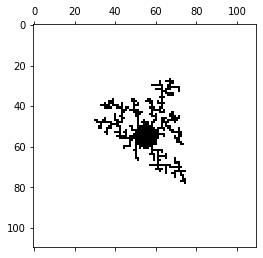

N = 110 
	Time taken to complete: 0:00:04.495437 
	Percentage of particles added to cluster: 13.62% 
	Percentage of grid occupied by cluster: 4.38% 
	Hole count: 80 
	Hole volume (normalized): 0.006611570247933884 
	Boundary length (normalized): 7.05 
	Exterior boundary length (normalized): 6.254545454545455 
	Boundary volume (normalized): 0.06396694214876034 
	Volume of symmetric difference (normalized): 0.06 
	First exit at: N/A 



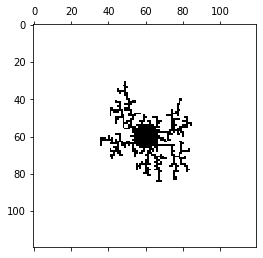

N = 120 
	Time taken to complete: 0:00:05.982235 
	Percentage of particles added to cluster: 13.95% 
	Percentage of grid occupied by cluster: 4.46% 
	Hole count: 24 
	Hole volume (normalized): 0.0016666666666666668 
	Boundary length (normalized): 7.62 
	Exterior boundary length (normalized): 7.133333333333334 
	Boundary volume (normalized): 0.06638888888888889 
	Volume of symmetric difference (normalized): 0.05 
	First exit at: N/A 



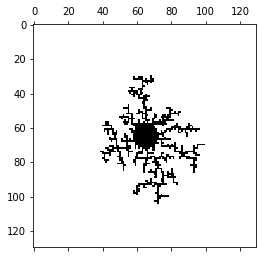

N = 130 
	Time taken to complete: 0:00:08.624459 
	Percentage of particles added to cluster: 17.15% 
	Percentage of grid occupied by cluster: 5.32% 
	Hole count: 33 
	Hole volume (normalized): 0.0019526627218934911 
	Boundary length (normalized): 10.15 
	Exterior boundary length (normalized): 9.569230769230769 
	Boundary volume (normalized): 0.08094674556213018 
	Volume of symmetric difference (normalized): 0.07 
	First exit at: N/A 



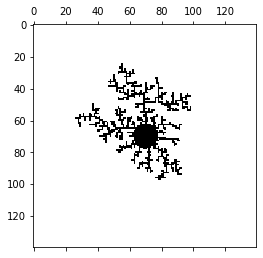

N = 140 
	Time taken to complete: 0:00:15.106989 
	Percentage of particles added to cluster: 17.14% 
	Percentage of grid occupied by cluster: 5.27% 
	Hole count: 12 
	Hole volume (normalized): 0.0006122448979591836 
	Boundary length (normalized): 11.17 
	Exterior boundary length (normalized): 10.885714285714286 
	Boundary volume (normalized): 0.08056122448979591 
	Volume of symmetric difference (normalized): 0.07 
	First exit at: N/A 



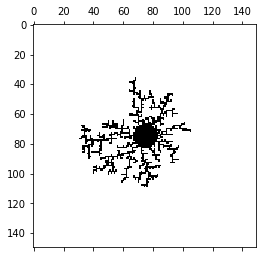

N = 150 
	Time taken to complete: 0:00:15.864931 
	Percentage of particles added to cluster: 16.10% 
	Percentage of grid occupied by cluster: 4.99% 
	Hole count: 45 
	Hole volume (normalized): 0.002 
	Boundary length (normalized): 11.09 
	Exterior boundary length (normalized): 10.386666666666667 
	Boundary volume (normalized): 0.07573333333333333 
	Volume of symmetric difference (normalized): 0.06 
	First exit at: N/A 



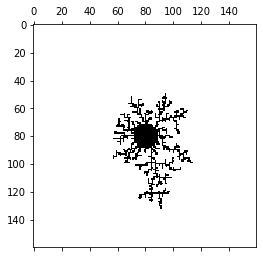

N = 160 
	Time taken to complete: 0:00:18.899794 
	Percentage of particles added to cluster: 13.30% 
	Percentage of grid occupied by cluster: 4.29% 
	Hole count: 36 
	Hole volume (normalized): 0.00140625 
	Boundary length (normalized): 9.80 
	Exterior boundary length (normalized): 9.2 
	Boundary volume (normalized): 0.060546875 
	Volume of symmetric difference (normalized): 0.05 
	First exit at: N/A 



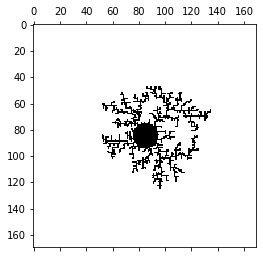

N = 170 
	Time taken to complete: 0:00:23.108204 
	Percentage of particles added to cluster: 16.84% 
	Percentage of grid occupied by cluster: 5.17% 
	Hole count: 60 
	Hole volume (normalized): 0.0020761245674740486 
	Boundary length (normalized): 13.14 
	Exterior boundary length (normalized): 12.223529411764705 
	Boundary volume (normalized): 0.07598615916955018 
	Volume of symmetric difference (normalized): 0.06 
	First exit at: N/A 



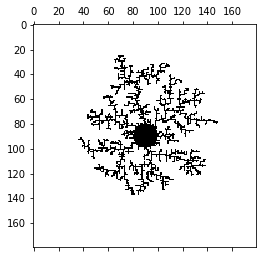

N = 180 
	Time taken to complete: 0:00:29.000085 
	Percentage of particles added to cluster: 26.45% 
	Percentage of grid occupied by cluster: 7.51% 
	Hole count: 136 
	Hole volume (normalized): 0.004197530864197531 
	Boundary length (normalized): 21.63 
	Exterior boundary length (normalized): 20.155555555555555 
	Boundary volume (normalized): 0.1205246913580247 
	Volume of symmetric difference (normalized): 0.10 
	First exit at: N/A 



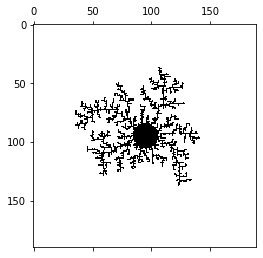

N = 190 
	Time taken to complete: 0:00:43.220230 
	Percentage of particles added to cluster: 20.39% 
	Percentage of grid occupied by cluster: 6.01% 
	Hole count: 65 
	Hole volume (normalized): 0.0018005540166204986 
	Boundary length (normalized): 17.25 
	Exterior boundary length (normalized): 16.42105263157895 
	Boundary volume (normalized): 0.09185595567867036 
	Volume of symmetric difference (normalized): 0.08 
	First exit at: N/A 



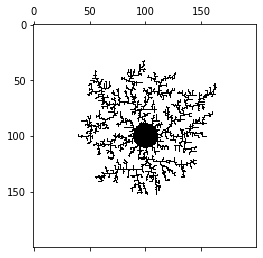

N = 200 
	Time taken to complete: 0:00:52.665540 
	Percentage of particles added to cluster: 26.85% 
	Percentage of grid occupied by cluster: 7.69% 
	Hole count: 87 
	Hole volume (normalized): 0.002175 
	Boundary length (normalized): 24.42 
	Exterior boundary length (normalized): 23.3 
	Boundary volume (normalized): 0.122025 
	Volume of symmetric difference (normalized): 0.10 
	First exit at: N/A 



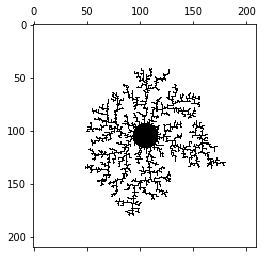

N = 210 
	Time taken to complete: 0:00:58.776694 
	Percentage of particles added to cluster: 26.76% 
	Percentage of grid occupied by cluster: 7.54% 
	Hole count: 164 
	Hole volume (normalized): 0.0037188208616780044 
	Boundary length (normalized): 25.32 
	Exterior boundary length (normalized): 23.82857142857143 
	Boundary volume (normalized): 0.12117913832199546 
	Volume of symmetric difference (normalized): 0.10 
	First exit at: N/A 



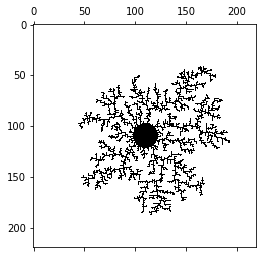

N = 220 
	Time taken to complete: 0:01:03.908339 
	Percentage of particles added to cluster: 31.32% 
	Percentage of grid occupied by cluster: 8.75% 
	Hole count: 171 
	Hole volume (normalized): 0.0035330578512396695 
	Boundary length (normalized): 30.84 
	Exterior boundary length (normalized): 29.009090909090908 
	Boundary volume (normalized): 0.14171487603305785 
	Volume of symmetric difference (normalized): 0.12 
	First exit at: N/A 



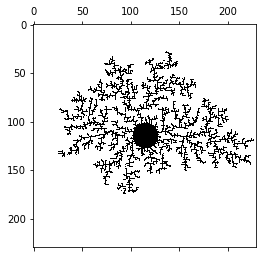

N = 230 
	Time taken to complete: 0:01:13.261217 
	Percentage of particles added to cluster: 34.94% 
	Percentage of grid occupied by cluster: 9.66% 
	Hole count: 175 
	Hole volume (normalized): 0.0033081285444234404 
	Boundary length (normalized): 36.47 
	Exterior boundary length (normalized): 34.86086956521739 
	Boundary volume (normalized): 0.15918714555765595 
	Volume of symmetric difference (normalized): 0.14 
	First exit at: N/A 



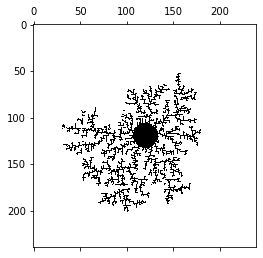

N = 240 
	Time taken to complete: 0:01:46.805784 
	Percentage of particles added to cluster: 25.94% 
	Percentage of grid occupied by cluster: 7.33% 
	Hole count: 115 
	Hole volume (normalized): 0.0019965277777777776 
	Boundary length (normalized): 27.90 
	Exterior boundary length (normalized): 26.491666666666667 
	Boundary volume (normalized): 0.11590277777777777 
	Volume of symmetric difference (normalized): 0.10 
	First exit at: N/A 



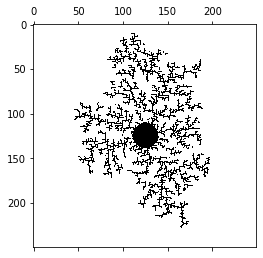

N = 250 
	Time taken to complete: 0:01:55.004606 
	Percentage of particles added to cluster: 32.64% 
	Percentage of grid occupied by cluster: 9.01% 
	Hole count: 244 
	Hole volume (normalized): 0.003904 
	Boundary length (normalized): 36.80 
	Exterior boundary length (normalized): 34.408 
	Boundary volume (normalized): 0.146752 
	Volume of symmetric difference (normalized): 0.13 
	First exit at: N/A 



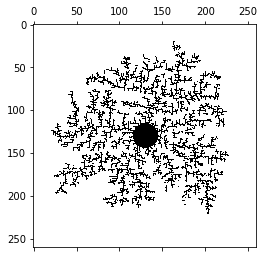

N = 260 
	Time taken to complete: 0:01:59.383898 
	Percentage of particles added to cluster: 44.06% 
	Percentage of grid occupied by cluster: 11.92% 
	Hole count: 800 
	Hole volume (normalized): 0.011834319526627219 
	Boundary length (normalized): 51.61 
	Exterior boundary length (normalized): 47.238461538461536 
	Boundary volume (normalized): 0.1987869822485207 
	Volume of symmetric difference (normalized): 0.17 
	First exit at: N/A 



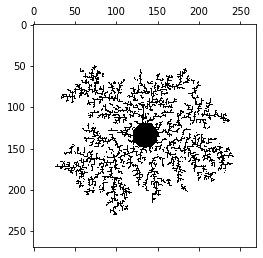

N = 270 
	Time taken to complete: 0:02:23.221260 
	Percentage of particles added to cluster: 35.70% 
	Percentage of grid occupied by cluster: 9.81% 
	Hole count: 203 
	Hole volume (normalized): 0.002784636488340192 
	Boundary length (normalized): 43.29 
	Exterior boundary length (normalized): 41.32592592592592 
	Boundary volume (normalized): 0.16065843621399176 
	Volume of symmetric difference (normalized): 0.14 
	First exit at: N/A 



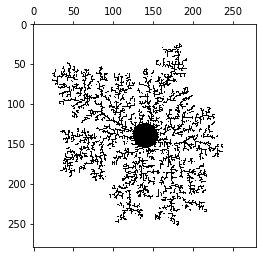

N = 280 
	Time taken to complete: 0:02:45.889435 
	Percentage of particles added to cluster: 40.79% 
	Percentage of grid occupied by cluster: 11.25% 
	Hole count: 756 
	Hole volume (normalized): 0.009642857142857142 
	Boundary length (normalized): 52.32 
	Exterior boundary length (normalized): 48.214285714285715 
	Boundary volume (normalized): 0.18698979591836734 
	Volume of symmetric difference (normalized): 0.16 
	First exit at: N/A 



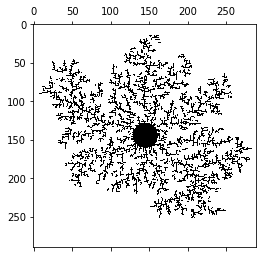

N = 290 
	Time taken to complete: 0:03:04.194456 
	Percentage of particles added to cluster: 47.72% 
	Percentage of grid occupied by cluster: 12.86% 
	Hole count: 618 
	Hole volume (normalized): 0.0073483947681331745 
	Boundary length (normalized): 62.30 
	Exterior boundary length (normalized): 58.56551724137931 
	Boundary volume (normalized): 0.21436385255648038 
	Volume of symmetric difference (normalized): 0.19 
	First exit at: N/A 



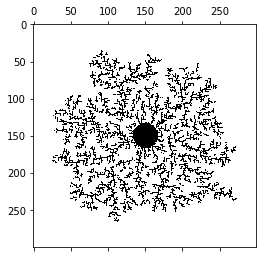

N = 300 
	Time taken to complete: 0:03:26.267597 
	Percentage of particles added to cluster: 46.24% 
	Percentage of grid occupied by cluster: 12.38% 
	Hole count: 666 
	Hole volume (normalized): 0.0074 
	Boundary length (normalized): 62.13 
	Exterior boundary length (normalized): 58.233333333333334 
	Boundary volume (normalized): 0.20746666666666666 
	Volume of symmetric difference (normalized): 0.18 
	First exit at: N/A 



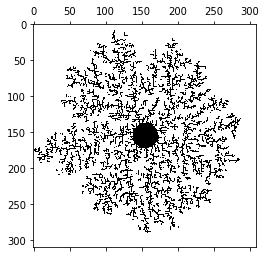

N = 310 
	Time taken to complete: 0:03:47.306066 
	Percentage of particles added to cluster: 53.34% 
	Percentage of grid occupied by cluster: 14.14% 
	Hole count: 1236 
	Hole volume (normalized): 0.012861602497398544 
	Boundary length (normalized): 73.99 
	Exterior boundary length (normalized): 68.39354838709677 
	Boundary volume (normalized): 0.23893860561914673 
	Volume of symmetric difference (normalized): 0.20 
	First exit at: N/A 



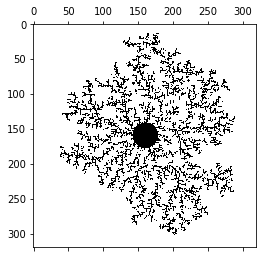

N = 320 
	Time taken to complete: 0:04:30.185018 
	Percentage of particles added to cluster: 45.71% 
	Percentage of grid occupied by cluster: 12.19% 
	Hole count: 728 
	Hole volume (normalized): 0.007109375 
	Boundary length (normalized): 64.98 
	Exterior boundary length (normalized): 60.7 
	Boundary volume (normalized): 0.20375 
	Volume of symmetric difference (normalized): 0.18 
	First exit at: N/A 



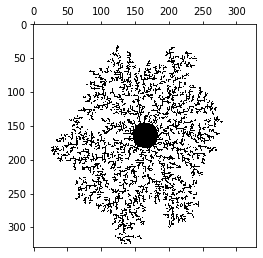

N = 330 
	Time taken to complete: 0:05:11.566779 
	Percentage of particles added to cluster: 44.20% 
	Percentage of grid occupied by cluster: 11.91% 
	Hole count: 1542 
	Hole volume (normalized): 0.014159779614325069 
	Boundary length (normalized): 64.98 
	Exterior boundary length (normalized): 59.50909090909091 
	Boundary volume (normalized): 0.19775022956841137 
	Volume of symmetric difference (normalized): 0.17 
	First exit at: N/A 



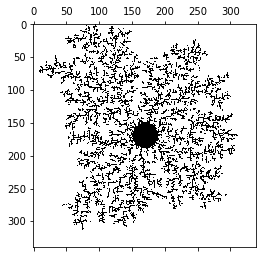

N = 340 
	Time taken to complete: 0:05:40.170228 
	Percentage of particles added to cluster: 54.55% 
	Percentage of grid occupied by cluster: 14.52% 
	Hole count: 688 
	Hole volume (normalized): 0.0059515570934256055 
	Boundary length (normalized): 83.24 
	Exterior boundary length (normalized): 78.60588235294118 
	Boundary volume (normalized): 0.24518166089965399 
	Volume of symmetric difference (normalized): 0.21 
	First exit at: N/A 



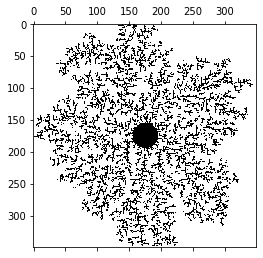

N = 350 
	Time taken to complete: 0:05:54.691007 
	Percentage of particles added to cluster: 65.76% 
	Percentage of grid occupied by cluster: 17.43% 
	Hole count: 989 
	Hole volume (normalized): 0.008073469387755102 
	Boundary length (normalized): 104.30 
	Exterior boundary length (normalized): 98.14571428571429 
	Boundary volume (normalized): 0.2978530612244898 
	Volume of symmetric difference (normalized): 0.25 
	First exit at: 0.009689795918367347 



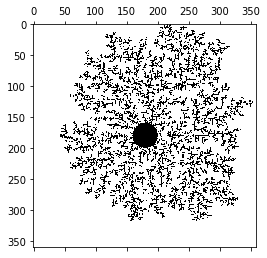

N = 360 
	Time taken to complete: 0:07:15.490205 
	Percentage of particles added to cluster: 55.77% 
	Percentage of grid occupied by cluster: 14.92% 
	Hole count: 1042 
	Hole volume (normalized): 0.008040123456790123 
	Boundary length (normalized): 91.01 
	Exterior boundary length (normalized): 85.74444444444444 
	Boundary volume (normalized): 0.252608024691358 
	Volume of symmetric difference (normalized): 0.22 
	First exit at: N/A 



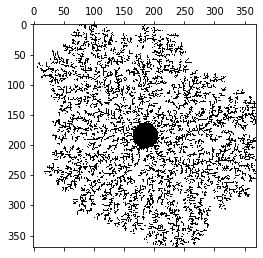

N = 370 
	Time taken to complete: 0:07:09.707963 
	Percentage of particles added to cluster: 72.39% 
	Percentage of grid occupied by cluster: 18.88% 
	Hole count: 1445 
	Hole volume (normalized): 0.010555149744338934 
	Boundary length (normalized): 119.92 
	Exterior boundary length (normalized): 112.66216216216216 
	Boundary volume (normalized): 0.3247552958363769 
	Volume of symmetric difference (normalized): 0.28 
	First exit at: 0.0081227173119065 



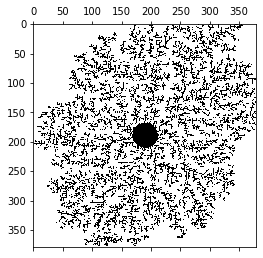

N = 380 
	Time taken to complete: 0:07:55.737653 
	Percentage of particles added to cluster: 76.20% 
	Percentage of grid occupied by cluster: 19.88% 
	Hole count: 1363 
	Hole volume (normalized): 0.009439058171745153 
	Boundary length (normalized): 129.65 
	Exterior boundary length (normalized): 122.0 
	Boundary volume (normalized): 0.34254847645429365 
	Volume of symmetric difference (normalized): 0.29 
	First exit at: N/A 



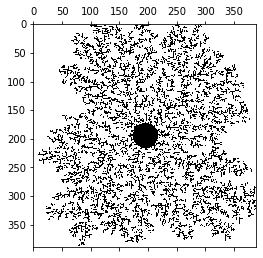

N = 390 
	Time taken to complete: 0:08:50.765446 
	Percentage of particles added to cluster: 75.13% 
	Percentage of grid occupied by cluster: 19.60% 
	Hole count: 3120 
	Hole volume (normalized): 0.020512820512820513 
	Boundary length (normalized): 130.93 
	Exterior boundary length (normalized): 120.18974358974359 
	Boundary volume (normalized): 0.3367061143984221 
	Volume of symmetric difference (normalized): 0.29 
	First exit at: N/A 



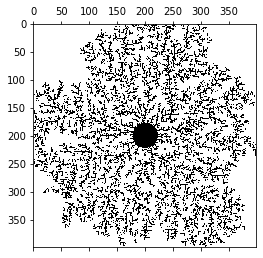

N = 400 
	Time taken to complete: 0:09:50.068902 
	Percentage of particles added to cluster: 78.27% 
	Percentage of grid occupied by cluster: 20.52% 
	Hole count: 95279 
	Hole volume (normalized): 0.59549375 
	Boundary length (normalized): 141.29 
	Exterior boundary length (normalized): 31.3075 
	Boundary volume (normalized): 0.35381875 
	Volume of symmetric difference (normalized): 0.30 
	First exit at: 0.0079 



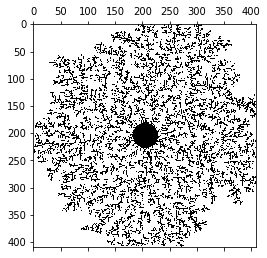

N = 410 
	Time taken to complete: 0:10:45.413762 
	Percentage of particles added to cluster: 77.17% 
	Percentage of grid occupied by cluster: 20.11% 
	Hole count: 1509 
	Hole volume (normalized): 0.008976799524092803 
	Boundary length (normalized): 142.02 
	Exterior boundary length (normalized): 134.0780487804878 
	Boundary volume (normalized): 0.3466805472932778 
	Volume of symmetric difference (normalized): 0.29 
	First exit at: 0.009161213563355145 



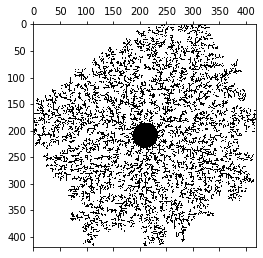

N = 420 
	Time taken to complete: 0:12:08.615596 
	Percentage of particles added to cluster: 71.92% 
	Percentage of grid occupied by cluster: 18.86% 
	Hole count: 106062 
	Hole volume (normalized): 0.6012585034013606 
	Boundary length (normalized): 135.30 
	Exterior boundary length (normalized): 29.742857142857144 
	Boundary volume (normalized): 0.3227551020408163 
	Volume of symmetric difference (normalized): 0.27 
	First exit at: 0.007732426303854875 



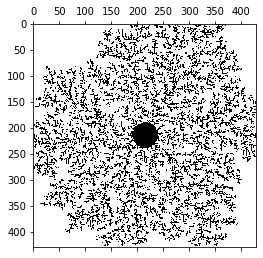

N = 430 
	Time taken to complete: 0:12:44.048095 
	Percentage of particles added to cluster: 81.56% 
	Percentage of grid occupied by cluster: 21.24% 
	Hole count: 5468 
	Hole volume (normalized): 0.029572742022714982 
	Boundary length (normalized): 157.46 
	Exterior boundary length (normalized): 143.65116279069767 
	Boundary volume (normalized): 0.3671227690643591 
	Volume of symmetric difference (normalized): 0.31 
	First exit at: 0.008480259599783668 



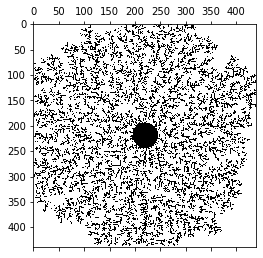

N = 440 
	Time taken to complete: 0:13:38.408004 
	Percentage of particles added to cluster: 84.37% 
	Percentage of grid occupied by cluster: 21.92% 
	Hole count: 5654 
	Hole volume (normalized): 0.029204545454545455 
	Boundary length (normalized): 166.51 
	Exterior boundary length (normalized): 152.34772727272727 
	Boundary volume (normalized): 0.37958677685950415 
	Volume of symmetric difference (normalized): 0.32 
	First exit at: 0.008440082644628099 



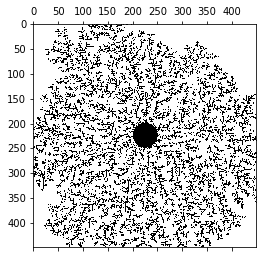

N = 450 
	Time taken to complete: 0:15:03.304553 
	Percentage of particles added to cluster: 84.60% 
	Percentage of grid occupied by cluster: 21.84% 
	Hole count: 55315 
	Hole volume (normalized): 0.2731604938271605 
	Boundary length (normalized): 169.51 
	Exterior boundary length (normalized): 97.58888888888889 
	Boundary volume (normalized): 0.3777382716049383 
	Volume of symmetric difference (normalized): 0.32 
	First exit at: 0.00945679012345679 



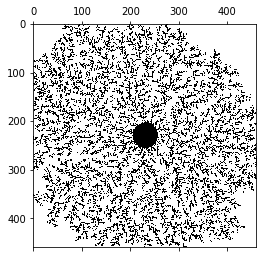

N = 460 
	Time taken to complete: 0:16:03.089839 
	Percentage of particles added to cluster: 87.65% 
	Percentage of grid occupied by cluster: 22.73% 
	Hole count: 121609 
	Hole volume (normalized): 0.5747117202268431 
	Boundary length (normalized): 181.14 
	Exterior boundary length (normalized): 48.095652173913045 
	Boundary volume (normalized): 0.39466446124763704 
	Volume of symmetric difference (normalized): 0.33 
	First exit at: 0.008638941398865785 



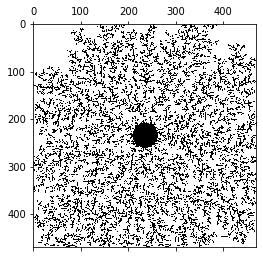

N = 470 
	Time taken to complete: 0:17:14.560032 
	Percentage of particles added to cluster: 91.34% 
	Percentage of grid occupied by cluster: 23.69% 
	Hole count: 11179 
	Hole volume (normalized): 0.05060660932548665 
	Boundary length (normalized): 192.73 
	Exterior boundary length (normalized): 170.6595744680851 
	Boundary volume (normalized): 0.40968764146672704 
	Volume of symmetric difference (normalized): 0.34 
	First exit at: 0.006337709370755998 



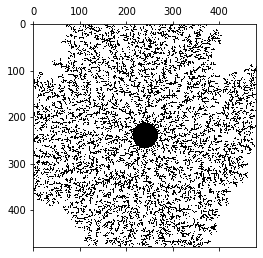

N = 480 
	Time taken to complete: 0:19:06.655497 
	Percentage of particles added to cluster: 84.45% 
	Percentage of grid occupied by cluster: 21.93% 
	Hole count: 154202 
	Hole volume (normalized): 0.6692795138888888 
	Boundary length (normalized): 181.18 
	Exterior boundary length (normalized): 22.391666666666666 
	Boundary volume (normalized): 0.37835069444444447 
	Volume of symmetric difference (normalized): 0.32 
	First exit at: 0.007352430555555556 



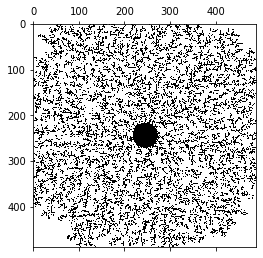

N = 490 
	Time taken to complete: 0:19:34.908038 
	Percentage of particles added to cluster: 93.31% 
	Percentage of grid occupied by cluster: 24.15% 
	Hole count: 4208 
	Hole volume (normalized): 0.01752603082049146 
	Boundary length (normalized): 204.98 
	Exterior boundary length (normalized): 190.88367346938776 
	Boundary volume (normalized): 0.41890045814244065 
	Volume of symmetric difference (normalized): 0.35 
	First exit at: 0.007334443981674302 



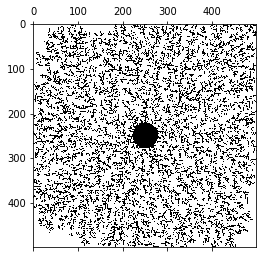

N = 500 
	Time taken to complete: 0:20:33.740754 
	Percentage of particles added to cluster: 95.53% 
	Percentage of grid occupied by cluster: 24.62% 
	Hole count: 131132 
	Hole volume (normalized): 0.524528 
	Boundary length (normalized): 213.64 
	Exterior boundary length (normalized): 61.614 
	Boundary volume (normalized): 0.427756 
	Volume of symmetric difference (normalized): 0.36 
	First exit at: 0.006048 

CPU times: user 4h 4min 20s, sys: 28.8 s, total: 4h 4min 48s
Wall time: 4h 7min 21s


In [208]:
%%time

M = 500
N_0 = 100

p = 0.25
T = 0.01
k = 0.01

step = 10

total_boundary_lengths = []
exterior_boundary_lengths = []
boundary_cell_count = []
hole_count = []
differences = []
first_exit_times = []

for N in range(N_0, M + step, step):
    start = time.time()

    matrix = np.zeros((N,N))

    # Circular seed cluster
    for row in range(N+1):
        for col in range(N+1):
            if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
                matrix[row,col] = 1

    cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
    valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))] # valid area to spawn particles (grid \ initial cluster)

    particles = distribute_particles(valid_area, p, matrix)

    P = len(particles)

    # walk the particles until either: (1) time runs out or (2) all particles attach to cluster
    particles_added = 0
    t = 0
    exit_time = []
    while particles_added < int(P) and t <= int(T*N**2): 
        step_particles(particles, matrix, N)
        for i in range(len(particles)):
            q = particles[i]
            if matrix[q[1], q[0]] == 2:
                particle_stuck = check_stuck(q, N, matrix)
                if particle_stuck:
                    to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                    cluster.extend(to_add)
                    particles_added += len(to_add)
                    # record exit time if one of the newly added particles is at the boundary 
#                     if len(exit_time) == 0:  
#                         for prt in to_add: 
#                             if check_atEdge(prt, N): 
#                                 exit_time.append(t/N**2) # normalize time by "slowing it back down" by a factor of 1/N^2
#                                 first_exit_times.append((N, exit_time[0])) 
        # second condition check iff we haven't exited yet
        if len(exit_time)==0 and check_boundary(matrix): 
            exit_time.append(t/N**2)
            first_exit_times.append((N,exit_time[0]))
            
        t+=1

    mat_copy = np.copy(matrix)
    mat_copy[mat_copy==2] = 0
    
    # "total" boundary length computation
    total_boundary_lengths.append(total_edge_count(cluster, mat_copy))
    
    # hole count and exterior boundary length computation
    hole_fill(mat_copy)
    num_holes = (mat_copy == -1).sum()
    hole_count.append(num_holes)
    exterior_boundary_lengths.append(total_edge_count(cluster, mat_copy))
    
    # boundary cell count
    b_cell_count = 0
    for col in range(1, N-1):
        for row in range(1, N-1):
            if matrix[col+1][row] == 1 and matrix[col-1][row] == 0:
                b_cell_count += 1
            elif matrix[col-1][row] ==1 and matrix[col+1][row] == 0:
                b_cell_count += 1
            elif matrix[col][row+1] == 1 and matrix[col][row-1] == 0:
                b_cell_count +=1 
            elif matrix[col][row-1] == 1 and matrix[col][row+1] == 0:
                b_cell_count += 1
    boundary_cell_count.append(b_cell_count)
    
    # symmetricity
    rotated_matrix = rotate_matrix(matrix)
    rotated_cluster = [(col,row) for col in range(N) for row in range(N)
                      if rotated_matrix[row][col]==1]
    orig_cluster = set(cluster)
    rotated_cluster = set(rotated_cluster)
    sd = orig_cluster.symmetric_difference(rotated_cluster)
    differences.append(len(sd))

    end = time.time()
    
    if (matrix==2).sum() > 0: 
        cmap = colors.ListedColormap(['white', 'black', 'white'])
    else: 
        cmap = colors.ListedColormap(['white', 'black'])

    plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
    plt.show()
    
    
    print(f"N = {N} \n\tTime taken to complete: {datetime.timedelta(seconds=(end-start))} \n\tPercentage of particles added to cluster: {(particles_added/P)*100:.2f}% \n\tPercentage of grid occupied by cluster: {(len(cluster)/N**2)*100:.2f}% \n\tHole count: {num_holes} \n\tHole volume (normalized): {num_holes/N**2} \n\tBoundary length (normalized): {total_boundary_lengths[-1]/N:.2f} \n\tExterior boundary length (normalized): {exterior_boundary_lengths[-1]/N} \n\tBoundary volume (normalized): {b_cell_count/N**2} \n\tVolume of symmetric difference (normalized): {differences[-1]/N**2:.2f} \n\tFirst exit at: {exit_time[0] if len(exit_time) > 0 else 'N/A'} \n")                
    
    
    

In [210]:
data_dict = {'total_boundary_lengths' : total_boundary_lengths,
             'exterior_boundary_lengths' : exterior_boundary_lengths,
             'boundary_cell_count' : boundary_cell_count,
             'hole_count' : hole_count,
             'symmetric_differences' : differences,
             'first_exit_times': first_exit_times
            }

# store 
with open('N=500_DLA_limit_properties.txt', 'wb') as fp:
    pickle.dump(data_dict, fp)

In [212]:
# open
with open('N=500_DLA_limit_properties.txt', 'rb') as fp:
    d = pickle.load(fp)

Text(0, 0.5, 'Boundary length')

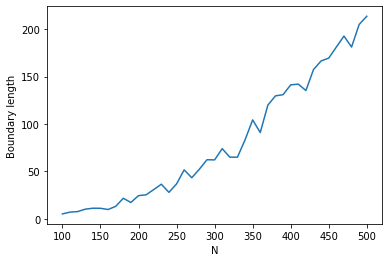

In [213]:
total_boundary_lengths_data = [(100+10*i, d['total_boundary_lengths'][i]/(100+10*i)) for i in range(len(d['total_boundary_lengths']))]

plt.plot(*zip(*total_boundary_lengths_data))
plt.xlabel('N')
plt.ylabel('Boundary length')

Text(0, 0.5, 'Exterior boundary length')

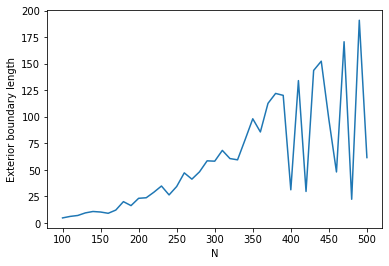

In [214]:
exterior_boundary_lengths_data = [(100+10*i, d['exterior_boundary_lengths'][i]/(100+10*i)) for i in range(len(d['exterior_boundary_lengths']))]

plt.plot(*zip(*exterior_boundary_lengths_data))
plt.xlabel('N')
plt.ylabel('Exterior boundary length')

Text(0, 0.5, 'Boundary volume')

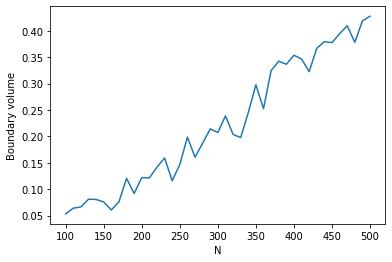

In [215]:
boundary_volume_data = [(100+10*i, d['boundary_cell_count'][i]/((100+10*i)**2)) for i in range(len(d['boundary_cell_count']))]

plt.plot(*zip(*boundary_volume_data))
plt.xlabel('N')
plt.ylabel('Boundary volume')

Text(0, 0.5, 'Hole volume')

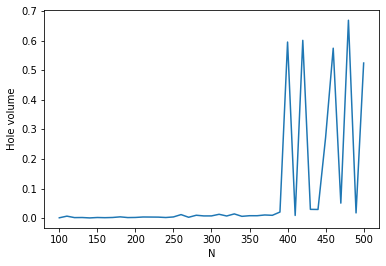

In [232]:
hole_volume_data = [(100+10*i, d['hole_count'][i]/((100+10*i)**2)) for i in range(len(d['hole_count']))]

plt.plot(*zip(*hole_volume_data))
plt.xlabel('N')
plt.ylabel('Hole volume')

Text(0, 0.5, 'Symmetric difference volume')

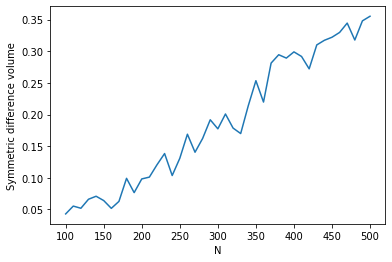

In [217]:
symmetric_diff_volume_data = [(100+10*i, d['symmetric_differences'][i]/((100+10*i)**2)) for i in range(len(d['symmetric_differences']))]

plt.plot(*zip(*symmetric_diff_volume_data))
plt.xlabel('N')
plt.ylabel('Symmetric difference volume')

In [218]:
print(d['first_exit_times'])

[(350, 0.009689795918367347), (370, 0.0081227173119065), (400, 0.0079), (410, 0.009161213563355145), (420, 0.007732426303854875), (430, 0.008480259599783668), (440, 0.008440082644628099), (450, 0.00945679012345679), (460, 0.008638941398865785), (470, 0.006337709370755998), (480, 0.007352430555555556), (490, 0.007334443981674302), (500, 0.006048)]


Text(0, 0.5, 'Time')

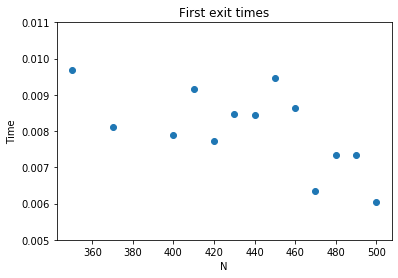

In [228]:
plt.scatter(*zip(*d['first_exit_times']))
plt.title('First exit times')
plt.ylim(.005, .011)
plt.xlabel('N')
plt.ylabel('Time')

# "Snapping" fix

In [54]:
matrix = np.zeros((20,20))
matrix[10,10] = 1
matrix[11,10] = 1
matrix[11,11] = 1
matrix[10,9] = 1
matrix[12,12] = 2
matrix[13,12] = 2
matrix[11,12] = 3
matrix[14, 13] = 2

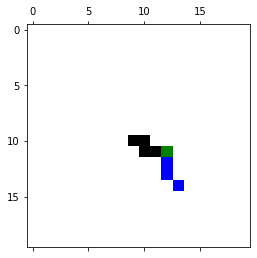

In [55]:
cmap = colors.ListedColormap(['white', 'black', 'blue', 'green'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

When a particle enters the green space, it attaches to the cluster and becomes black. Instantaneously, the two blue particles below also become part of the cluster by virtue of their positions. We use flood-fill to implement this feature.

We keep this position in the matrix value 2. It and all connected 2s will becomes 1s.

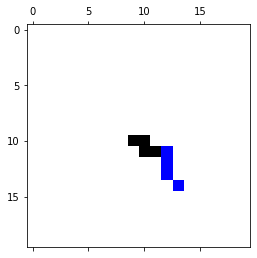

In [57]:
matrix[11,12] = 2
cmap = colors.ListedColormap(['white', 'black', 'blue'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

In [58]:
flood_fill(matrix, (11,12), 1)

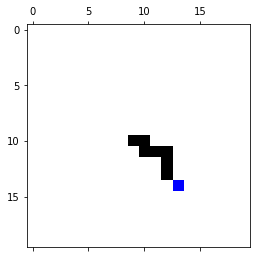

In [59]:
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

Now we have to implement this in the simulation. Note that we need to keep track of the particles that are added.

In [60]:
# this function is an analogue of the flood-fill algorithm, but returns a list of pairs (x,y) which denote 
# each of the particles added to the cluster
def snap_to_cluster(data, start_coords, fill_value):
    
    xsize, ysize = data.shape
    orig_value = data[start_coords[0], start_coords[1]]
    
    stack = set(((start_coords[0], start_coords[1]),))
    
    if fill_value == orig_value: 
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")
    
    ret = [] # will contain the positions of particles that are added to the cluster
    
    while stack: 
        x, y = stack.pop()
    
        if data[x,y] == orig_value:
            data[x,y] = fill_value
            ret.append((y,x))
            
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))
                
    return ret

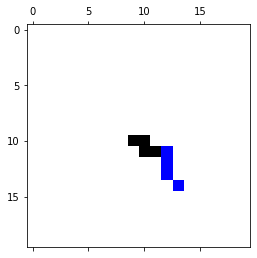

In [61]:
matrix = np.zeros((20,20))
matrix[10,10] = 1
matrix[11,10] = 1
matrix[11,11] = 1
matrix[10,9] = 1
matrix[12,12] = 2
matrix[13,12] = 2
matrix[11,12] = 2
matrix[14, 13] = 2

cmap = colors.ListedColormap(['white', 'black', 'blue'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

In [62]:
additions_to_cluster = snap_to_cluster(matrix, (11,12), 1)
additions_to_cluster

[(12, 11), (12, 12), (12, 13)]

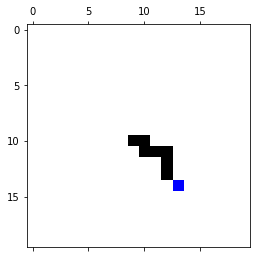

In [64]:
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

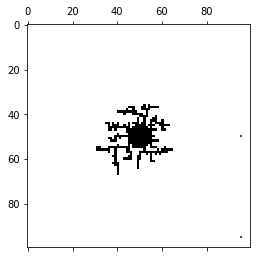

CPU times: user 2.86 s, sys: 14 ms, total: 2.87 s
Wall time: 2.98 s


In [78]:
%%time

N = 100
p = 0.25
T = 0.01
k = 0.01

S = 0.05

s = .02
c = .1

matrix = np.zeros((N,N))

# circular seed
for row in range(N):
    for col in range(N):
        if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
            matrix[row,col] = 1

# square seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-s*N and col < N/2+s*N and row > N/2-s*N and row < N/2+s*N:
#             matrix[row,col]=1


# # cross seed cluster
# for row in range(N):
#     for col in range(N):
#         if col > N/2-c*N and col < N/2 +c*N and row > N/2 - s*N and row < N/2 + s*N:
#             matrix[row,col]=1
#         elif col > N/2-s*N and col < N/2 +s*N and row > N/2 - c*N and row < N/2 + c*N:
#             matrix[row,col]=1
            

cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))]

particles = distribute_particles(valid_area, p, matrix)

P = len(particles)

particles_added = 0
t = 0

while particles_added < int(P) and t <= int(T*N**2): 
    step_particles(particles, matrix, N)
    for i in range(len(particles)):
        q = particles[i]
        if matrix[q[1], q[0]] == 2:
            particle_stuck = check_stuck(q, N, matrix)
            if particle_stuck:
                to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                cluster.extend(to_add)
                particles_added += len(to_add)
    t+=1
    
matrix[N-N//20, N-N//20] = 3
matrix[N//2, N-(N//20)] = 3

if (matrix==2).sum() > 0: 
    cmap = colors.ListedColormap(['white', 'black', 'white', 'green'])
else: 
    cmap = colors.ListedColormap(['white', 'black', 'green'])
plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
plt.show()

In [226]:
x=4

# Experiment: terminating when all particles attach

We now run the experiment and terminate the growth process when all the particles attach. Note this is different from above where the process is terminated at some terminal time. We also test this for relatively small values of $p$.

In [10]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [140]:
%%time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



M = 1000
N = 100

p = 0.15
T = 0.01
k = 0.01

step = 20

total_boundary_lengths = []
exterior_boundary_lengths = []
boundary_cell_count = []
hole_count = []
differences = []
first_exit_times = []
time_taken = []


while N <= M: 
    
    start = time.time() 

    matrix = np.zeros((N,N))

    # Circular seed cluster
    for row in range(N+1):
        for col in range(N+1):
            if (col-N/2)**2 + (row-N/2)**2 < (k*N**2)/math.pi: 
                matrix[row,col] = 1

    cluster = [t[::-1] for t in list(zip(*np.where(matrix==1)))]
    valid_area = [t[::-1] for t in list(zip(*np.where(matrix==0)))] # valid area to spawn particles (grid \ initial cluster)

    particles = distribute_particles(valid_area, p, matrix)

    P = len(particles)

    # walk the particles until either: (1) time runs out or (2) all particles attach to cluster
    particles_added = 0
    t = 0
    exit_time = []
    while particles_added < int(P): 
        step_particles(particles, matrix, N)
        for i in range(len(particles)):
            q = particles[i]
            if matrix[q[1], q[0]] == 2:
                particle_stuck = check_stuck(q, N, matrix)
                if particle_stuck:
                    to_add = snap_to_cluster(matrix, (q[1], q[0]), 1)
                    cluster.extend(to_add)
                    particles_added += len(to_add)
                    # record exit time if one of the newly added particles is at the boundary 
                    if len(exit_time) == 0 and check_boundary(matrix):  
                        exit_time.append(t/N**2) # normalize time by "slowing it back down" by a factor of 1/N^2
                        first_exit_times.append((N, exit_time[0])) 
        t+=1

    mat_copy = np.copy(matrix)
    mat_copy[mat_copy==2] = 0
    
    # "total" boundary length computation
    total_boundary_lengths.append(total_edge_count(cluster, mat_copy))
    
    # hole count and exterior boundary length computation
    hole_fill(mat_copy)
    num_holes = (mat_copy == -1).sum()
    hole_count.append(num_holes)
    exterior_boundary_lengths.append(total_edge_count(cluster, mat_copy))
    
    # boundary cell count
    b_cell_count = 0
    for col in range(1, N-1):
        for row in range(1, N-1):
            if matrix[col+1][row] == 1 and matrix[col-1][row] == 0:
                b_cell_count += 1
            elif matrix[col-1][row] ==1 and matrix[col+1][row] == 0:
                b_cell_count += 1
            elif matrix[col][row+1] == 1 and matrix[col][row-1] == 0:
                b_cell_count +=1 
            elif matrix[col][row-1] == 1 and matrix[col][row+1] == 0:
                b_cell_count += 1
    boundary_cell_count.append(b_cell_count)
    
    # symmetricity
    rotated_matrix = rotate_matrix(matrix)
    rotated_cluster = [(col,row) for col in range(N) for row in range(N)
                      if rotated_matrix[row][col]==1]
    orig_cluster = set(cluster)
    rotated_cluster = set(rotated_cluster)
    sd = orig_cluster.symmetric_difference(rotated_cluster)
    differences.append(len(sd))
    
    # record how long it took for all particles to attach
    time_taken.append(t/N**2)

    end = time.time()
    
    if (matrix==2).sum() > 0: 
        cmap = colors.ListedColormap(['white', 'black', 'white'])
    else: 
        cmap = colors.ListedColormap(['white', 'black'])

    plt.matshow(matrix, interpolation = 'nearest', cmap = cmap)
    plt.show()
    
    print(f"N = {N} \n\tActual time to complete: {datetime.timedelta(seconds=(end-start))} \n\tPhysical time to complete: {time_taken[-1]} \n\tPercentage of particles added to cluster: {(particles_added/P)*100:.2f}% \n\tPercentage of grid occupied by cluster: {(len(cluster)/N**2)*100:.2f}% \n\tHole count: {num_holes} \n\tHole volume (normalized): {num_holes/N**2} \n\tBoundary length (normalized): {total_boundary_lengths[-1]/N:.2f} \n\tExterior boundary length (normalized): {exterior_boundary_lengths[-1]/N} \n\tBoundary volume (normalized): {b_cell_count/N**2} \n\tVolume of symmetric difference (normalized): {differences[-1]/N**2:.2f} \n\tFirst exit at: {exit_time[0] if len(exit_time) > 0 else 'N/A'} \n")                
    
    if N >= 100 and N <= 500:
        N += 10 
    elif N > 500 and N <= 750: 
        N += 15
    elif N > 750 and N <= 1000: 
        N += 20

KeyboardInterrupt: 